Reference Paper:



Creating dataset and dataloader to give out noisy image(Y), image(X)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip "/content/drive/My Drive/JPEGImages.zip"

# !unzip "/content/PolyU-Real-World-Noisy-Images-Dataset-master.zip"

In [0]:
import pandas as pd
import os
import random
random.seed(2)

files = os.listdir("/content/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages")
files = [file[:-4] for file in files if "real" in file]

random.shuffle(files)

train = files[:71]
val = files[71:86]
test = files[86:100]

# print(len(files))

train_df = pd.DataFrame({"files":train})
train_df.to_csv("/content/train_data.csv",header=None,index=None)

val_df = pd.DataFrame({"files":val})
val_df.to_csv("/content/val_data.csv",header=None,index=None)

test_df = pd.DataFrame({"files":test})
test_df.to_csv("/content/test_data.csv",header=None,index=None)

In [0]:
# Project: ML 7641
# Author: Sai Sateesh Gudapati

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from skimage import io, transform
from skimage.color import rgb2ycbcr
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import pickle

%matplotlib inline

plt.ion()   # interactive mode

device = torch.device('cuda')

transformations class




In [0]:
## Define transforms

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, n_image = sample['original_image'], sample['noisy_image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w,1))
        n_img = transform.resize(n_image,(new_h, new_w,1))
        
#         print(img.shape)

        return {'noisy_image': n_img, 'original_image': img}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, n_image = sample['original_image'], sample['noisy_image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        # print(h,new_h)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        n_image = n_image[top: top + new_h,
                      left: left + new_w]

        # image = image[top: top + new_h,
                      # left: left + new_w]

        image = image[top+8: top + new_h-8,
                      left+8: left + new_w-8]



        s = self.output_size[0]
        # image = transform.resize(image, (s, s,1))
        # n_image = transform.resize(n_image,(s, s,1))

        return {'original_image': image, 'noisy_image': n_image}



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, n_image = sample['original_image'], sample['noisy_image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        n_image = n_image.transpose((2, 0, 1))
        return {'original_image': torch.from_numpy(image),
                'noisy_image': torch.from_numpy(n_image)}

In [0]:
# scale = Rescale((400,400))
# to_tensor = ToTensor()
composed = transforms.Compose([RandomCrop(200),ToTensor()])
# composed = transforms.Compose([ToTensor()])

dataset class

In [0]:
class NoisyImageDataset(Dataset):
    """Using PASCAL VOC dataset to create Y,X samples."""

    def __init__(self, csv_file, root_dir, transform=composed):
        """
        Args:
            csv_file (string): Path to the csv file with image names.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_data = pd.read_csv(csv_file)
        # print(self.image_data)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.image_data.iloc[idx, 0]+".jpg")
        
        image = io.imread(img_name)
        # image = rgb2ycbcr(image)
        image = image.astype("float64")
        
        ## apply noise on the original image
        row,col,ch= image.shape
        mean = 0
        sigma = 10
        # sigma = np.random.randint(10,51)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy_image = image + gauss
        noisy_image = np.clip(noisy_image,0,255.0)
        # noisy_image = (255.0*(noisy_image-np.min(noisy_image))/(np.max(noisy_image)-np.min(noisy_image)))
        # noisy_image = noisy_image.astype("uint8")

        # image = image.astype("uint8")
        # image = rgb2ycbcr(image)

        # noisy_image = rgb2ycbcr(noisy_image)
        
        # print(noisy_image[:,:,0].shape)
        sample = {'noisy_image': noisy_image, 'original_image': image}
        # sample = {'noisy_image': noisy_image, 'original_image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
noise_dataset = NoisyImageDataset("/content/drive/My Drive/PASCAL_VOC_2010_splits/train.txt",
                                 "/content/JPEGImages/")

# noise_dataset = NoisyImageDataset("/content/train_data.csv",
                                #  "/content/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages")

val_dataset = NoisyImageDataset("/content/drive/My Drive/PASCAL_VOC_2010_splits/valid.txt",
                                 "/content/JPEGImages/")

o,n = noise_dataset[6].values()
print(n.shape,o.shape)

torch.Size([3, 33, 33]) torch.Size([3, 17, 17])


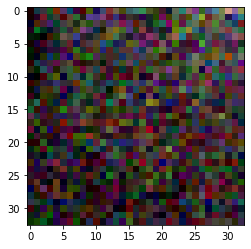

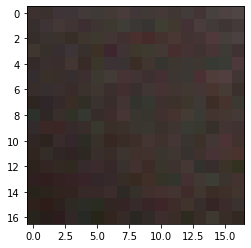

In [10]:
## visualize crop transform

# Apply each of the above transforms on sample.
# fig = plt.figure()

# crop = RandomCrop(256)
sample = noise_dataset[100]

plt.imshow(sample["noisy_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

plt.imshow(sample["original_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

In [0]:
## create dataloader

dataloader = DataLoader(noise_dataset, batch_size=128,
                        shuffle=True, num_workers=8)

valloader = DataLoader(val_dataset, batch_size=32,
                        shuffle=True, num_workers=2)

In [0]:
## Defining 3 layer DN-Resnet 

class DNNet(nn.Module):
    def __init__(self):
        super(DNNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=0),
            nn.ReLU())

    ## forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [0]:
## Output of the code
class DNNet_res(nn.Module):
    def __init__(self):
        super(DNNet_res, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        self.res_layer1 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        # nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.res_layer2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1))
        self.rel_layer = nn.Sequential(nn.ReLU())

    ## forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        res1 = self.res_layer1(out)
        res2 = self.res_layer2(res1)
        out = self.rel_layer(out+res2)
        out = self.layer3(out)
        return out

In [0]:
## define model

model = DNNet()
model = model.double()
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
## resned model
model2 = DNNet_res()
model2 = model2.double()
model2.to(device)

criterion = nn.MSELoss()


# model_dict = model2.state_dict()
# model_dict.update(model.state_dict())
# model2.load_state_dict(model_dict)

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [0]:
# import time
# # Train the model
# total_step = len(dataloader)
# step_loss_list = []
# train_loss_list = []
# val_loss_list = []
# num_epochs = 200

# training_start_time = time.time()

# for epoch in range(150,num_epochs):
#     train_loss = 0
#     for i, batch in enumerate(dataloader):
#         step_start_time = time.time()
#         # Run the forward pass
#         images = batch['noisy_image'].to(device)
#         labels = batch['original_image'].to(device)
#         outputs = model2(images)
#         # print(outputs.shape,labels.shape)
#         loss = criterion(outputs, labels)
#         step_loss_list.append(loss.item())
#         train_loss+=loss.item()

#         # Backprop and perform Adam optimisation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # time_per_step = time.time() - step_start_time

#         if (i + 1) % 10 == 0:
#           print(i)
#             # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time_per_step: {:.2f}s'
#                   # .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),time_per_step))

#     # print("Training loss = {:.2f} at Epoch {}".format(train_loss / total_step,epoch+1))
    
#     train_loss_list.append(train_loss)
#     #At the end of the epoch, do a pass on the validation set
#     total_val_loss = 0
#     for i, batch in enumerate(valloader):
#         images = batch['noisy_image'].to(device)
#         labels = batch['original_image'].to(device)
#         # #Wrap tensors in Variables
#         # inputs, labels = Variable(inputs), Variable(labels)
        
#         #Forward pass
#         val_outputs = model2(images)
#         val_loss = criterion(val_outputs, labels)
#         total_val_loss += val_loss.item()
    
#     val_loss_list.append(total_val_loss)
#     print("Training loss = {:.4f} || Validation loss = {:.4f} at Epoch {}".format(train_loss / total_step,total_val_loss / len(valloader),epoch+1))

#     if (epoch+1)%50 == 0:
#       torch.save(model.state_dict(), "/content/drive/My Drive/dn_resnet_{}.pt".format(epoch+1))
#       loss_dict = {"train_loss":train_loss_list,"val_loss":val_loss_list}
#       output = open('/content/drive/My Drive/dn_resnet_{}.pkl'.format(epoch+1), 'wb')
#       pickle.dump(loss_dict, output)
#       output.close()  

# print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [48]:
model_weights = torch.load("/content/drive/My Drive/dn_resnet_200.pt")
model2.load_state_dict(model_weights)

<All keys matched successfully>

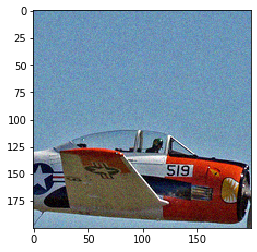

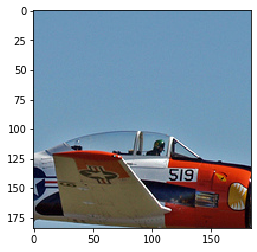

In [62]:
## test dataset 
# test_dataset = NoisyImageDataset("/content/test_data.csv",
                                #  "/content/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages")


test_dataset = NoisyImageDataset("/content/drive/My Drive/PASCAL_VOC_2010_splits/test.txt",
                                 "/content/JPEGImages/")

sample = test_dataset[789]

plt.imshow(sample["noisy_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

plt.imshow(sample["original_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

real, noisy = sample["original_image"], sample["noisy_image"]

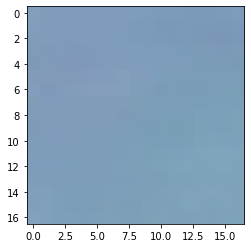

(17, 17, 3) (33, 33, 3)
(17, 17, 3) (17, 17, 3)
22.15043765939707 37.14582637427177
0.1567457110306444 0.9218648328465692


In [16]:
## PSNR calculations
denoised_img = model(noisy.cuda().unsqueeze(0)).cpu().squeeze().detach().numpy().transpose(1, 2, 0)

plt.imshow(denoised_img.astype("uint8"))
plt.show()

from skimage.measure import compare_psnr,compare_ssim

real = real.numpy().transpose(1, 2, 0)
noisy = noisy.numpy().transpose(1, 2, 0)
print(real.shape, noisy.shape)
h,w,_ = noisy.shape
noisy = noisy[8: h-8,8:w-8]
print(real.shape, noisy.shape)



real_psnr = compare_psnr(real,noisy ,255)
model_psnr = compare_psnr(real, denoised_img,255)

real_ssim = compare_ssim(X=real,Y=noisy ,data_range=255,multichannel=True)
model_ssim = compare_ssim(X=real,Y=denoised_img,data_range=255,multichannel=True)


print(real_psnr,model_psnr)
print(real_ssim,model_ssim)

In [63]:
## psnr stats

from tqdm import tqdm

psnrs = []
ssims = []

for sample in tqdm(test_dataset):
  real, noisy = sample["original_image"], sample["noisy_image"]
  ## PSNR calculations
  denoised_img = model2(noisy.cuda().unsqueeze(0)).cpu().squeeze().detach().numpy().transpose(1, 2, 0)

  real = real.numpy().transpose(1, 2, 0)
  noisy = noisy.numpy().transpose(1, 2, 0)
  # print(real.shape, noisy.shape)
  h,w,_ = noisy.shape
  noisy = noisy[8: h-8,8:w-8]
  # print(real.shape, noisy.shape)



  real_psnr = compare_psnr(real,noisy ,255)
  model_psnr = compare_psnr(real, denoised_img,255)

  psnrs.append((real_psnr,model_psnr))

  real_ssim = compare_ssim(X=real,Y=noisy ,data_range=255,multichannel=True)
  model_ssim = compare_ssim(X=real,Y=denoised_img,data_range=255,multichannel=True)

  ssims.append((real_ssim,model_ssim))

100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


In [64]:
s1 = [0,0]
s2 = [0,0]

for i in range(len(psnrs)):
  s1[0]+= psnrs[i][0]
  s1[1]+= psnrs[i][1]
  s2[0]+= ssims[i][0]
  s2[1]+= ssims[i][1]

n = len(psnrs)
print(n)

print(s1[0]/n,s1[1]/n)
print(s2[0]/n,s2[1]/n)


1000
28.33220882527781 31.851465353778252
0.727654950178674 0.8983358455430167


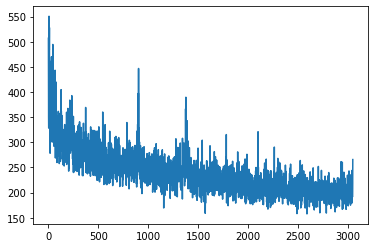

In [67]:
## loss_graph

plt.figure()
plt.plot([i for i in range(len(loss_list[100:]))],loss_list[100:])
plt.show()

In [0]:
## using dn_resnet 3 layer 

##psnr averages with 50 sigma, 200 crop size
15.136374220687854 25.660894430825916
0.2428739748678796 0.7007467620272538

##psnr averages with 25 sigma, 200 crop size
20.638378524430895 28.94534913880096
0.44044571893195866 0.8309102299896335

##psnr averages with 10 sigma, 200 crop size
28.326973727236943 31.92724932201631
0.7337025276088065 0.905754182067197

##psnr averages with 50 sigma, 33 crop size
15.165316808916467 26.774576088119332
0.22419024109154162 0.6936942462835167

In [0]:
## using dn_resnet 5 layer 

##psnr averages with 50 sigma, 200 crop size
15.133383081478295 25.589555946495725
0.24256199125582 0.6951465017547604

##psnr averages with 25 sigma, 200 crop size
20.64502681763687 29.021970645182865
0.43563045750411244 0.8272381795223122

##psnr averages with 10 sigma, 200 crop size
28.33220882527781 31.851465353778252
0.727654950178674 0.8983358455430167

##psnr averages with 50 sigma, 33 crop size
15.211295747400914 26.68453466147755
0.21251021171598705 0.6824065642205944

In [0]:
class DeepConvolutionalModel(nn.Module):
    def __init__(self, depth=17):
        super(DeepConvolutionalModel, self).__init__()
        self.layers = []
        self.num_channels = 64
        self.layers.append(nn.Conv2d(3, self.num_channels, kernel_size=3, padding=1, bias=True))
        self.layers.append(nn.ReLU(inplace=True))

        for _ in range(depth-2):
            self.layers.append(nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1, bias=False))
            self.layers.append(nn.BatchNorm2d(self.num_channels, eps=0.0001, momentum=0.95))
            self.layers.append(nn.ReLU(inplace=True))
        
        self.layers.append(nn.Conv2d(self.num_channels, 3, kernel_size=3, padding=1, bias=True))
        self.model = nn.Sequential(*self.layers)
        self._initialize_weights()
    
    def forward(self, noisy_image):
        residual = self.model(noisy_image)
        return noisy_image - residual
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                # print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [0]:
import torch.nn.init as init
model = DeepConvolutionalModel(depth = 9)
model = model.double()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction="sum")

In [102]:
torch.max(noisy)

tensor(187., dtype=torch.float64)

In [0]:
model_dict = model.state_dict()

In [173]:
model_dict.keys()

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer2.0.weight', 'layer2.0.bias', 'layer3.0.weight', 'layer3.0.bias'])

In [0]:
model2 = DNNet_res()
model2 = model2.double()

In [185]:
model2.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[ 2.4164e-02, -3.1114e-03, -1.2375e-02,  ..., -4.1830e-02,
                          1.6610e-02, -3.3114e-02],
                        [ 3.5304e-02, -1.8268e-02, -1.4242e-02,  ...,  4.9322e-02,
                         -6.8897e-02,  2.5572e-02],
                        [ 4.8980e-02, -6.2359e-02, -6.2126e-02,  ...,  6.3529e-02,
                          1.8808e-02, -1.6482e-02],
                        ...,
                        [-3.8141e-02,  3.5697e-02, -2.0863e-02,  ..., -1.3498e-02,
                          7.6344e-03,  3.5453e-02],
                        [-2.6762e-02,  6.4717e-02, -4.5098e-02,  ..., -2.7230e-02,
                         -2.5272e-02,  4.2337e-02],
                        [ 9.0522e-03, -3.5811e-02,  3.8451e-02,  ..., -4.8435e-03,
                          6.2756e-02, -6.1577e-02]],
              
                       [[-6.5369e-02, -1.9204e-02, -4.7566e-02,  ..., -5.8867e-02,
                         -3.8

In [0]:
## loss graphs
# read python dict back from the file
import pickle
t_loss = []
v_loss = []
for i in [50,100,150,200]:
  pkl_file = open("/content/drive/My Drive/dn_resnet_{}.pkl".format(i), 'rb')
  mydict = pickle.load(pkl_file)
  pkl_file.close()
  t_loss.extend(mydict["train_loss"])
  v_loss.extend(mydict["val_loss"])




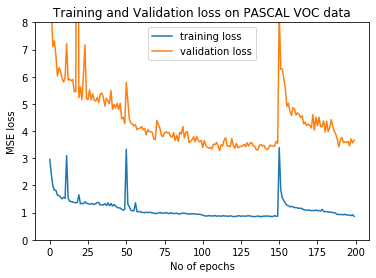

In [55]:
plt.figure()
plt.plot([i for i in range(200)],[i/8020 for i in t_loss])
plt.plot([i for i in range(200)],[i/999 for i in v_loss])
plt.ylim(0,8)
plt.title("Training and Validation loss on PASCAL VOC data")
plt.xlabel("No of epochs")
plt.ylabel("MSE loss")
plt.gca().legend(("training loss","validation loss"))
plt.savefig("/content/drive/My Drive/dn_resnet_pascal_loss.jpg")
plt.show()

In [0]:
# t_loss

In [0]:
df = pd.read_csv("/content/drive/My Drive/PASCAL_VOC_2010_splits/train.txt")

In [24]:
len(df)

8020

In [0]:
# Input to the model
x = torch.randn(1, 3, 33, 33, requires_grad=True).type(torch.DoubleTensor)
# torch_out = torch_model(x)

# Export the model
torch.onnx.export(model2,x,"Downloads/abc2.onnx",input_names = ['Noisy Image Input'],output_names = ["Denoised Image Output"])